# Adaboost
In this tutorial, we will implement the AdaBoost algorithm.

In [269]:
# Package imports
import matplotlib.pyplot as plt
import numpy as np
import sklearn
import sklearn.datasets
import matplotlib

# Display plots inline
%matplotlib inline

## Dataset

Besides the datasets we have already worked with, [scikit-learn](http://scikit-learn.org/) provides some functions to generate toy data. Here, we will use [`make_circles`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_circles.html), which generates two nested circles.

The blue dots belong to class 1 and the red dots belong to class -1.

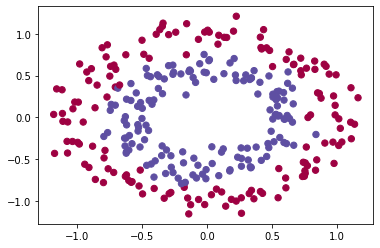

In [270]:
# Generate a dataset and plot it
np.random.seed(0)

X_train, y_train = sklearn.datasets.make_circles(300, factor=0.6, noise=0.10)
y_train = y_train.reshape((-1,1))
y_train[y_train == 0] = -1

plt.scatter(X_train[:,0], X_train[:,1], s=40, c=y_train, cmap=plt.cm.Spectral)
plt.show()

## Decision Stumps

For illustration purposes, we will use very naive decision stumps. 

A decision stump is defined by a threshold on a single feature:
- If the feature value is larger than the threshold, the stump predicts 1. 
- If the feature value is smaller than the threshold, the stump predicts -1.

We might also want to flip the stump's prediction. For that purpose, we include the `orientation` parameter.

In [271]:
class Stump(object):
    def __init__(self, feature, threshold, orientation="larger"):
        self.feature = feature
        self.threshold = threshold
        self.orientation = orientation
    
    def predict(self, X):
        if self.orientation == "larger":
            p = X[:, self.feature] >= self.threshold
        else:
            p = X[:, self.feature] <= self.threshold
        
        p = p.astype(int).reshape(-1,1)
        p[p == 0] = -1
        return p
    
    def __str__(self):
        return f"[Classifier feat{self.feature} {'>=' if self.orientation == 'larger' else '<='} {self.threshold} ?]"

In [272]:
h1 = Stump(0, 0.3)
h2 = Stump(0, 0.3, orientation="smaller")

In [273]:
h1.predict(X_train)

array([[-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],

In [274]:
h2.predict(X_train)

array([[ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [-1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],
       [ 1],
       [-1],
       [ 1],
       [-1],
       [ 1],
       [ 1],
       [-1],
       [-1],
       [ 1],
       [ 1],

Let's define a couple of decision stumps for our Boosting algorithm to work with:

In [275]:
h1 = Stump(0, -1.7)  # is the value in feature 0 larger than -1.7 -> predict 1, else -1
h3 = Stump(0, 0.4)
h5 = Stump(0, 0.6, orientation="smaller")
h7 = Stump(0, -0.9, orientation="smaller")

h2 = Stump(1, 0.5, orientation="smaller")  # is the value in feature 1 smaller than 0.5 -> predict 1, else -1
h4 = Stump(1, 0.01)
h6 = Stump(1, -0.7)
h8 = Stump(1, 1.4, orientation="smaller")

classifiers = [h1, h2, h3, h4, h5, h6, h7, h8]

After you have implemented the algorithm, you may want to experiment with randomly created classifiers.

In [276]:
def createClassifiers(n, features, min_threshold, max_threshold):
    classifiers = []
    for i in range(n):
        feat = np.random.choice(features)
        thre = np.random.uniform(low=min_threshold, high=max_threshold)
        classifiers.append(Stump(feat, thre))
    return classifiers

#classifiers = createClassifiers(20, [0, 1], X_train.min(), X_train.max())

# Adaboost Algorithm

## Task 1: Implement a function to calculate the error rate $\epsilon^t$

$$ \epsilon^t = \sum_{i \in (wrong)} w_i^t$$

In [277]:
def calcErrorRate(X, y, classifier, weights):
    """
    This function should return the error rate of the given classifier and a boolean mask on y that indicates the misclassified data points
    'classifier' is of type Stump, so you can call its predict() function
    'weights' is an array of shape (N,1) with N being the number of data points in X (and y)
    """
    y_hat = classifier.predict(X)
    mask_wrong = y_hat != y
    
    error_rate = weights[mask_wrong].sum()
    
    return error_rate, mask_wrong

## Task 2: Implement a function to calculate the ensemble's predictions $H(x)$

$$ H(x) = sign(\alpha^1 h^1(x) + \alpha^2 h^2(x) + \ldots)$$

In [278]:
def H_predict(X, classifiers, alphas):
    """
    This function should calculate the classification of the ensemble
    'classifiers' is a list of classifiers of type Stump
    'alphas' is a list of alpha values (voting powers)
    
    The function should return an array of shape (N,1) containing binary classifications -1 or 1
    """
    y_hat = np.zeros((len(X),1))
    
    assert(len(classifiers) == len(alphas))
    
    for classifier, alpha in zip(classifiers, alphas):
        y_hat += alpha * classifier.predict(X)

    return np.sign(y_hat).astype(int)

## Task 3: Implement the ADABOOST algorithm

The voting power $\alpha^t$ is given by:
$$\alpha^t = \frac{1}{2} \ln \left(\frac{1 - \epsilon^t}{\epsilon^t}\right)$$

The weight update for a **correctly** classified data point is given by:
$$w_i^{t+1} = \frac{1}{2} \frac{1}{1 - \epsilon^t} w_i^t$$

The weight update for an **INcorrectly** classified data point is given by:
$$w_i^{t+1} = \frac{1}{2} \frac{1}{\epsilon^t} w_i^t$$

In [279]:
def adaboost(X, y, classifiers, n_rounds=20):
    """
    The AdaBoost algorithm combines several weak classifiers into a single strong ensemble classifier.
    
    'classifiers': A list of classifiers of type Stump
    'n_rounds': The number of classifiers to combine sequentially (stopping criterion)
    
    returns: 
        A list of 'n_rounds' classifiers
        A list of 'n_rounds' voting parameters (alpha values)
    """
    
    N = len(X)
    w = np.ones((N, 1)) / N
    
    # Collect the chosen classifiers in these lists
    ensemble = []
    alphas = []
    
    for round in range(n_rounds):
    
        print(f"Round {round}")
    
        best_score = 0.
        best_classifier = None

        # for i, classifier in enumerate(classifiers):
        #     err_rate, mask_wrong = calcErrorRate(X, y, classifier, w)        
        #     alpha = 0.5 * np.log((1. - err_rate) / err_rate)

        #     score = abs(err_rate - 0.5)

        #     if score > best_score:
        #         best_score = score
        #         best_classifier = (i, classifier, err_rate, mask_wrong, alpha)

        #     #print(f"{classifier} ErrorRate: {err_rate} VotingPower: {alpha}")

        # i, classifier, err_rate, mask_wrong, alpha = best_classifier
        # print("Best classifier: ", i, classifier, err_rate, alpha)

        # # Append best classifier to ensemble set
        # ensemble.append(classifier)
        # alphas.append(alpha)

        # # Update weights
        # w[mask_wrong] = 0.5 * 1./err_rate * w[mask_wrong]
        # w[~mask_wrong] = 0.5 * 1./(1.-err_rate) * w[~mask_wrong]
        # #w[mask_wrong] = 0.5 * (w[mask_wrong] / w[mask_wrong].sum())
        # #w[~mask_wrong] = 0.5 * (w[~mask_wrong] / w[~mask_wrong].sum())
        
        # # Calculate error rate of entire ensemble H(x)
        # Y_hat = H_predict(X, ensemble, alphas)
        # H_mask_wrong = Y_hat != y
        # H_error_rate = H_mask_wrong.sum() / N
        
        # print(f"Boosted Ensemble's ErrorRate: {H_error_rate}\n")
        
        for i, classifier in enumerate(classifiers):
            error, mask = calcErrorRate(X,y,classifier,w)
            alpha = 1/2 * np.log((1 - error) / error)# = ln
            score = abs(error - 1/2)
            if score > best_score:
                best_score = score
                best_classifier = (i, classifier, error, mask, alpha) 
        i, classifier, error, mask, alpha = best_classifier
        print(i, classifier, error, alpha)
        
        # Append best classifier to ensemble set
        ensemble.append(classifier)
        alphas.append(alpha)   
        
        # Update weights
        for i in range(len(w)):
            if not mask[i]:
                w[i] *= 1/2 * (1/(1-error))
            else:
                w[i] *= 1/2 * (1/error)
            
        # Calculate error rate of entire ensemble H(x)
        Y_hat = H_predict(X, ensemble, alphas)
        H_mask_wrong = Y_hat != y
        H_error_rate = H_mask_wrong.sum() / N
        print(f"Boosted Ensemble's ErrorRate: {H_error_rate}\n")
        
    return ensemble, alphas

In [280]:
ensemble, alphas = adaboost(X_train, y_train, classifiers, n_rounds=20)

Round 0
4 [Classifier feat0 <= 0.6 ?] 0.38000000000000006 0.24477411265935275
Boosted Ensemble's ErrorRate: 0.38

Round 1
0 [Classifier feat0 >= -1.7 ?] 0.5797962648556877 -0.16096854850105005
Boosted Ensemble's ErrorRate: 0.38

Round 2
5 [Classifier feat1 >= -0.7 ?] 0.38510211928952776 0.2339738311846996
Boosted Ensemble's ErrorRate: 0.29

Round 3
0 [Classifier feat0 >= -1.7 ?] 0.5841162413351486 -0.1698471057378877
Boosted Ensemble's ErrorRate: 0.29

Round 4
1 [Classifier feat1 <= 0.5 ?] 0.3812158815262552 0.24219531024599014
Boosted Ensemble's ErrorRate: 0.24

Round 5
0 [Classifier feat0 >= -1.7 ?] 0.5571960791178221 -0.11489507478951733
Boosted Ensemble's ErrorRate: 0.24

Round 6
6 [Classifier feat0 <= -0.9 ?] 0.6000984754610827 -0.20293771968579152
Boosted Ensemble's ErrorRate: 0.33

Round 7
0 [Classifier feat0 >= -1.7 ?] 0.5834017078481766 -0.16837677775379034
Boosted Ensemble's ErrorRate: 0.17666666666666667

Round 8
5 [Classifier feat1 >= -0.7 ?] 0.4096237037078732 0.1827605907

# Illustration of Decision Boundary

Indeed, it does not look super impressive... But we used only a couple of very naive classifiers.

Try the random classifier generator and increase the number of rounds of the algorithm.

In [281]:
# Helper function to plot a decision boundary.
def plot_decision_boundary(X, y, pred_func):
    # Set min and max values and give it some padding
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Evaluate the function on the entire grid
    Z = pred_func(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, Z, cmap=plt.cm.Spectral)
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Spectral)

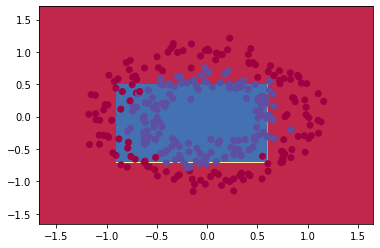

In [282]:
plot_decision_boundary(X_train, y_train, lambda x: H_predict(x, ensemble, alphas))

Round 0
Best classifier:  4 [Classifier feat0 <= 0.6 ?] 0.38000000000000006 0.24477411265935275
Boosted Ensemble's ErrorRate: 0.38

Round 1
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5797962648556877 -0.16096854850105005
Boosted Ensemble's ErrorRate: 0.38

Round 2
Best classifier:  5 [Classifier feat1 >= -0.7 ?] 0.38510211928952776 0.2339738311846996
Boosted Ensemble's ErrorRate: 0.29

Round 3
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5841162413351486 -0.1698471057378877
Boosted Ensemble's ErrorRate: 0.29
Round 4
Best classifier:  1 [Classifier feat1 <= 0.5 ?] 0.3812158815262552 0.24219531024599014
Boosted Ensemble's ErrorRate: 0.24
Round 5
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5571960791178221 -0.11489507478951733
Boosted Ensemble's ErrorRate: 0.24
Round 6
Best classifier:  6 [Classifier feat0 <= -0.9 ?] 0.6000984754610827 -0.20293771968579152
Boosted Ensemble's ErrorRate: 0.33
Round 7
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5834017078481766 -0.16837677775379034
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 8
Best classifier:  5 [Classifier feat1 >= -0.7 ?] 0.4096237037078732 0.18276059074608508
Boosted Ensemble's ErrorRate: 0.3466666666666667
Round 9
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5663262145876402 -0.13343882904057017
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 10
Best classifier:  4 [Classifier feat0 <= 0.6 ?] 0.4139490573584963 0.17383190111927424
Boosted Ensemble's ErrorRate: 0.2833333333333333
Round 11
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.556287959330491 -0.11305513883382753
Boosted Ensemble's ErrorRate: 0.24
Round 12
Best classifier:  6 [Classifier feat0 <= -0.9 ?] 0.5836293972242004 -0.16884522593334755
Boosted Ensemble's ErrorRate: 0.22
Round 13
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5716459774147342 -0.1442849349577809
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 14
Best classifier:  6 [Classifier feat0 <= -0.9 ?] 0.5626663881540395 -0.1259952869110771
Boosted Ensemble's ErrorRate: 0.22
Round 15
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5556869838623483 -0.11183792585507
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 16
Best classifier:  1 [Classifier feat1 <= 0.5 ?] 0.433313359027808 0.1341726651807556
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 17
Best classifier:  5 [Classifier feat1 >= -0.7 ?] 0.4448680986183834 0.11071395751355277
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 18
Best classifier:  0 [Classifier feat0 >= -1.7 ?] 0.5684523827896572 -0.13776984655776747
Boosted Ensemble's ErrorRate: 0.17666666666666667
Round 19
Best classifier:  6 [Classifier feat0 <= -0.9 ?] 0.5563386124407764 -0.11315774660790581
Boosted Ensemble's ErrorRate: 0.17666666666666667